# KCAP module demonstration

## Setup
Import the usual suspects.

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

pi = np.pi

KCAP isn't a proper package yet, so we can't import it directly and have to add it to the path manually for now.

In [2]:
import importlib

import sys
sys.path.append("/Users/yooken/Research/KiDS/kcap/")
import kcap.twopoint
import kcap.cosmosis_utils

Set paths to the CSL and cosebis directories. Once everything is properly merged into kcap that won't be necessary anymore but for now this setup makes development easier.

In [3]:
csl_path = "../../cosmosis-standard-library/"
cosebis_path = "../../cosebis/"

## Compute predictions
Now compute the angular power spectra, correlation functions, and cosebis for the KV450 n(z) and two values of $A_s$.

In [4]:
importlib.reload(kcap.cosmosis_utils)
importlib.reload(kcap.twopoint)
        
nofz = {"shear" : ["../examples/kv450_data/nofz/B/Nz_DIR_z0.1t0.3.asc",
                   "../examples/kv450_data/nofz/B/Nz_DIR_z0.3t0.5.asc",
                   "../examples/kv450_data/nofz/B/Nz_DIR_z0.5t0.7.asc",
                   "../examples/kv450_data/nofz/B/Nz_DIR_z0.7t0.9.asc",
                   "../examples/kv450_data/nofz/B/Nz_DIR_z0.9t1.2.asc"]}

cls = {}
xis = {}
cosebis = {}

for A_s in [2.0e-9, 2.5e-9]:
    twopoint = kcap.twopoint.TwoPoint(probes={"cl"      : [("shear", "shear")],
                                              "xi"      : [("shear", "shear")],
                                              "cosebis" : [("shear", "shear")],
                                             },
                                      parameters={"cosmological_parameters" : {"A_s" : A_s}},
                                      transfer_function="camb",
                                      nofz_files=nofz,
                                      module_paths={"CSL_PATH" : csl_path,
                                                    "COSEBIS_PATH" : cosebis_path,
                                                   },
                                      module_configs={"cosebis" : {"n_max" : 5}}
                                     )
    
    ini = twopoint.get_pipeline_config()
    
    cl, ell, bin_names = twopoint.angular_power_spectrum(probes=("shear", "shear"), return_bin_names=True)
    cls[A_s] = cl
    
    xi_plus, theta = twopoint.correlation_function(probes=("shear", "shear"), kind="plus",
                                            return_bin_names=False)
    xi_minus, _ = twopoint.correlation_function(probes=("shear", "shear"), kind="minus",
                                             return_bin_names=False)
    xis[A_s] = xi_plus, xi_minus
    
    c, modes = twopoint.cosebis(probes=("shear", "shear"), return_bin_names=False)
    cosebis[A_s] = c

COSMOSIS_SRC_DIR. Module paths assumed to be relative
to current directory,  /Users/yooken/Research/KiDS/kcap/notebooks

Parameter Priors
----------------
cosmological_parameters--omega_m    ~ delta(0.3)
cosmological_parameters--h0         ~ delta(0.7)
cosmological_parameters--omega_b    ~ delta(0.05)
cosmological_parameters--tau        ~ delta(0.089)
cosmological_parameters--n_s        ~ delta(0.96)
cosmological_parameters--omega_k    ~ delta(0.0)
cosmological_parameters--w          ~ delta(-1.0)
cosmological_parameters--wa         ~ delta(0.0)
cosmological_parameters--a_s        ~ delta(2.1e-09)
halo_model_parameters--log10_theat  ~ delta(7.8)

n(z) set to histogram mode. Bin centers are 0.025000 higher than edges.
Found 5 samples and 120 bins in redshift in file ../examples/kv450_data/nofz/B/Nz_DIR_z0.1t0.3.asc ../examples/kv450_data/nofz/B/Nz_DIR_z0.3t0.5.asc ../examples/kv450_data/nofz/B/Nz_DIR_z0.5t0.7.asc ../examples/kv450_data/nofz/B/Nz_DIR_z0.7t0.9.asc ../examples/kv450_data/n

Print the configuration ("ini file") that is being used.

In [5]:
print(ini)

[DEFAULT]
hmx_path = %(KCAP_PATH)s/HMx/
csl_path = ../../cosmosis-standard-library/
cosebis_path = ../../cosebis/
kcap_path = /Users/yooken/Research/KiDS/kcap

[runtime]
sampler = 

[pipeline]
values = 
priors = 
likelihoods = 
extra_output = 
quiet = T
timing = F
debug = F
modules = consistency camb HMx load_nofz projection cl2xi cosebis

[consistency]
file = %(CSL_PATH)s/utility/consistency/consistency_interface.py

[camb]
file = %(CSL_PATH)s/boltzmann/camb/camb.so
mode = all
lmax = 2500
feedback = 0
zmax = 6.0
nz = 100
background_zmax = 6.0
background_nz = 600

[HMx]
file = %(HMX_PATH)s/lib/cosmosis_interface.so
fields = matter
nk = 128
kmin = 0.001
kmax = 10.0
nz = 32
zmin = 0.0
zmax = 5.999
verbose = 0
dimensionless_power_spectrum = 0
p_lin_source = external
matter_matter_section_name = matter_power_nl
hm_mode = hmx
one_parameter_hmcode = F
ihm = 18

[load_nofz]
file = %(CSL_PATH)s/number_density/load_nz/load_nz.py
filepath = ../examples/kv450_data/nofz/B/Nz_DIR_z0.1t0.3.asc ../ex

## Make plots

Text(0.5,0.98,'Angular power spectra')

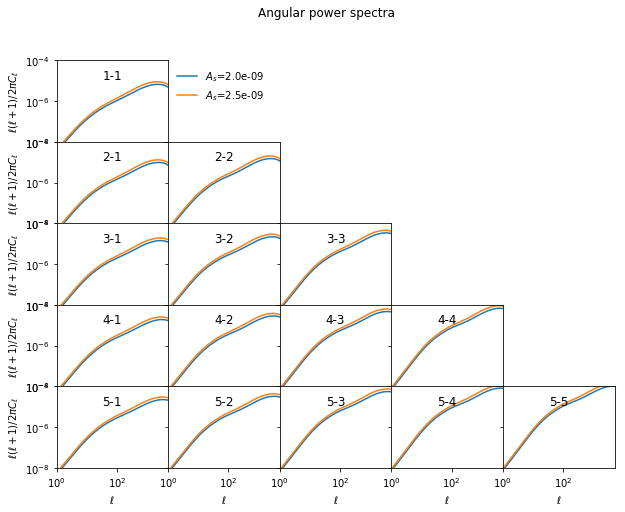

In [6]:
n_z_bin = len(nofz["shear"])

fig, ax = plt.subplots(n_z_bin, n_z_bin, sharex=True, sharey=True,
                       figsize=(2*n_z_bin, 1.5*n_z_bin))
fig.subplots_adjust(hspace=0, wspace=0)

u = ell*(ell+1)/(2*pi)

for A_s, tomo_cl in cls.items():
    for cl, bin_name in zip(tomo_cl, bin_names):
        i, j = int(bin_name[0])-1, int(bin_name[1])-1
        ax[i,j].plot(ell, u*cl, label=f"$A_s$={A_s:.1e}")
        ax[i,j].set_title("{}-{}".format(*bin_name), y=0.7)
        if i == n_z_bin-1:
            ax[i,j].set_xlabel(r"$\ell$")
        if j == 0:
            ax[i,j].set_ylabel(r"$\ell(\ell+1)/2\pi C_\ell$")
        if i != j:
            ax[j,i].axis("off")

            
ax[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1))

for p in ax.flat:
    p.set_xscale("log")
    p.set_yscale("log")
    p.set_xlim(1, 5000)
    p.set_ylim(1e-8, 1e-4)
    
fig.suptitle("Angular power spectra")

Text(0.5,0.98,'Correlation functions')

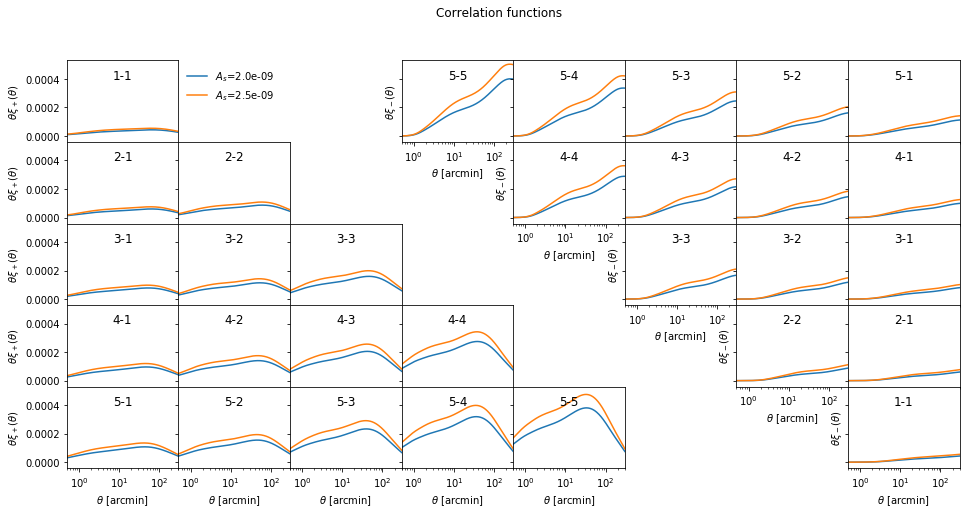

In [7]:
n_z_bin = len(nofz["shear"])

fig, ax = plt.subplots(n_z_bin, n_z_bin+3, sharex=False, sharey=True,
                       figsize=(2*(n_z_bin+3), 1.5*n_z_bin))
fig.subplots_adjust(hspace=0, wspace=0)

theta_arcmin = theta*180/pi*60

u = theta_arcmin

for A_s, (tomo_xi_plus, tomo_xi_minus) in xis.items():
    for xi, bin_name in zip(tomo_xi_plus, bin_names):
        i, j = int(bin_name[0])-1, int(bin_name[1])-1
        ax[i,j].plot(theta_arcmin, u*xi, label=f"$A_s$={A_s:.1e}")
        ax[i,j].set_title(r"{}-{}".format(*bin_name), y=0.7)
        if i == n_z_bin-1:
            ax[i,j].set_xlabel(r"$\theta$ [arcmin]")
        if j == 0:
            ax[i,j].set_ylabel(r"$\theta\xi_+(\theta)$")
            
    for xi, bin_name in zip(tomo_xi_minus, bin_names):
        i, j = int(bin_name[0]), int(bin_name[1])
        ax[-i,-j].plot(theta_arcmin, u*xi, label=f"$A_s$={A_s:.1e}")
        ax[-i,-j].set_title(r"{}-{}".format(*bin_name), y=0.7)
        if i == j:
            ax[-i,-j].set_xlabel(r"$\theta$ [arcmin]")
            ax[-i,-j].set_ylabel(r"$\theta\xi_-(\theta)$")
        

for i in range(n_z_bin):
    ax[i,i+1].axis("off")
    ax[i,i+2].axis("off")
    
ax[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1))

for p in ax.flat:
    p.set_xscale("log")
#     p.set_yscale("log")
    p.set_xlim(0.5, 300)
#     p.set_ylim(1e-5, 1e-3)

fig.suptitle("Correlation functions")

Text(0.5,0.98,'COSEBIS')

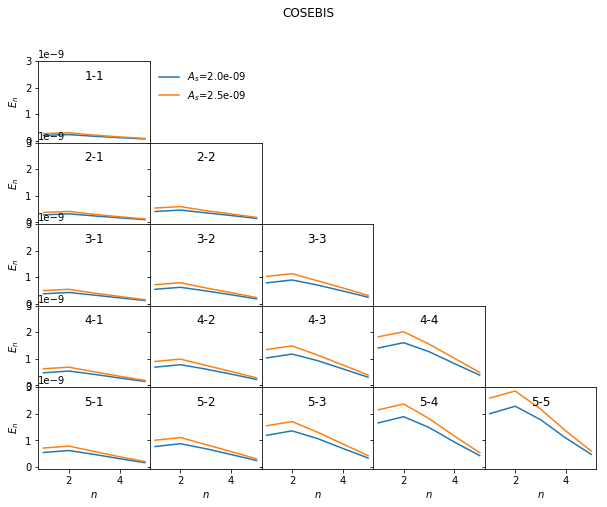

In [8]:
n_z_bin = len(nofz["shear"])

fig, ax = plt.subplots(n_z_bin, n_z_bin, sharex=True, sharey=True,
                       figsize=(2*n_z_bin, 1.5*n_z_bin))
fig.subplots_adjust(hspace=0, wspace=0)

u = 1

for A_s, tomo_cosebis in cosebis.items():
    for c, bin_name in zip(tomo_cosebis, bin_names):
        i, j = int(bin_name[0])-1, int(bin_name[1])-1
        ax[i,j].plot(modes, c, label=f"$A_s$={A_s:.1e}")
        ax[i,j].set_title("{}-{}".format(*bin_name), y=0.7)
        if i == n_z_bin-1:
            ax[i,j].set_xlabel(r"$n$")
        if j == 0:
            ax[i,j].set_ylabel(r"$E_n$")
        if i != j:
            ax[j,i].axis("off")

            
ax[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1))

# for p in ax.flat:
#     p.set_xscale("log")
#     p.set_yscale("log")
#     p.set_xlim(1, 5000)
#     p.set_ylim(1e-8, 1e-4)

fig.suptitle("COSEBIS")